In [104]:
import networkx as nx
import matplotlib.pyplot as plt

class NetworkGraph:
    def __init__(self):
        """Initializes a new network graph."""
        self.graph = nx.Graph()
        self.default_capacities = {
            'Fiber': 1000,    # Default capacity of 1000 Mbps for Fiber
            'WiFi': 200,      # Default capacity of 200 Mbps for WiFi
            'Satellite': 5000 # Default capacity of 5000 Mbps for Satellite
        }
        self.orbital_distance = 35786 * 2  # Round trip orbital distance for satellite in kilometers
        self.setup_network()

    def setup_network(self):
        """Initial setup of network with predefined connections."""
        self.add_edge("Server", "Router1", {'Fiber': 50, 'Satellite': self.orbital_distance})
        self.add_edge("Router1", "Router2", {'WiFi': 10, 'Satellite': self.orbital_distance})
        self.add_edge("Router2", "Destination", {'Satellite': self.orbital_distance})

    def add_edge(self, from_node, to_node, network_types_distances):
        """Adds an edge with specified network types and distances."""
        for network_type, distance in network_types_distances.items():
            capacity = self.default_capacities[network_type]
            self.update_edge(from_node, to_node, network_type, capacity, 0, distance)

    def update_edge(self, from_node, to_node, network_type, capacity, new_occupancy, distance):
        """Updates or creates an edge with new occupancy, capacity, and distance."""
        self.graph.add_edge(from_node, to_node, **{network_type: {
            'capacity': capacity,
            'occupancy': new_occupancy,
            'distance': distance,
            'effective_capacity': capacity  # Initially set to full capacity
        }})

    def calculate_latency(self, from_node, to_node, network_type):
        """Calculates the estimated latency for a given network type."""
        edge_data = self.graph[from_node][to_node][network_type]
        distance_km = edge_data['distance']
        speed = {
            'Fiber': 200000,
            'WiFi': 300000,
            'Satellite': 300000
        }[network_type]

        propagation_latency = distance_km / speed
        return propagation_latency

    def simulate_message_transmission(self, start, end, message_size):
        """Simulate the transmission of a message checking bandwidth and latency constraints."""
        all_paths = nx.all_simple_paths(self.graph, source=start, target=end)
        viable_paths = []
        for path in all_paths:
            is_viable = True
            path_details = []
            for i in range(len(path) - 1):
                u, v = path[i], path[i+1]
                best_link = None
                for net_type, details in self.graph[u][v].items():
                    if details['capacity'] >= message_size and (not best_link or self.calculate_latency(u, v, net_type) < self.calculate_latency(u, v, best_link)):
                        best_link = net_type
                if best_link:
                    details = self.graph[u][v][best_link]
                    latency = self.calculate_latency(u, v, best_link)
                    path_details.append((u, v, best_link, details['occupancy'], details['effective_capacity'], latency))
                else:
                    is_viable = False
                    break
            if is_viable:
                total_latency = sum(detail[-1] for detail in path_details)
                if total_latency < 1:  # Less than 1 second
                    viable_paths.append((path_details, total_latency))

        if viable_paths:
            best_path = min(viable_paths, key=lambda x: x[1])
            path_description = "\n".join(
                f"{detail[0]} -> {detail[1]} via {detail[2]}: Occupancy={detail[3]}%, Effective Capacity={detail[4]} Mbps, Segment Latency={detail[5]:.4f} s"
                for detail in best_path[0]
            )
            return f"Best path with total latency {best_path[1]:.4f} seconds:\n{path_description}"
        else:
            return "No viable path found"

    def draw_network(self):
        """Draws the network graph using matplotlib."""
        pos = nx.spring_layout(self.graph)
        nx.draw(self.graph, pos, with_labels=True, node_color='lightblue', edge_color='gray')
        plt.show()


Best path with total latency 0.2389 seconds:
Server -> Router1 via Fiber: Occupancy=0%, Effective Capacity=1000 Mbps, Segment Latency=0.0003 s
Router1 -> Router2 via WiFi: Occupancy=0%, Effective Capacity=200 Mbps, Segment Latency=0.0000 s
Router2 -> Destination via Satellite: Occupancy=0%, Effective Capacity=5000 Mbps, Segment Latency=0.2386 s


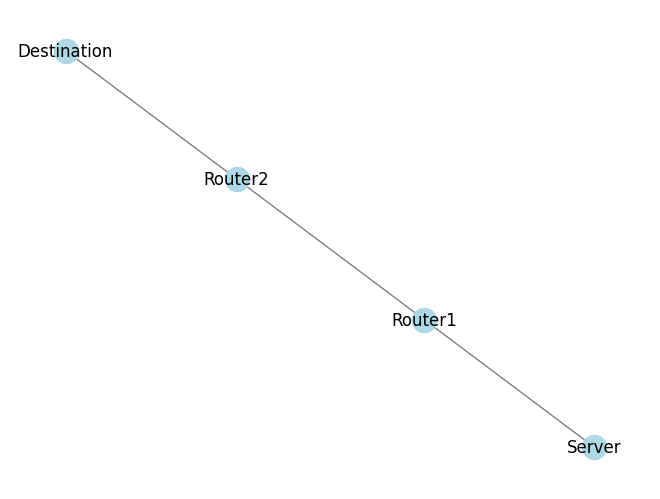

In [107]:
# Usage example to test the NetworkGraph class
if __name__ == "__main__":
    net = NetworkGraph()
    result = net.simulate_message_transmission("Server", "Destination", 100)  # Simulate sending a 6000MB message
    print(result)
    net.draw_network()
